In [27]:
#bring in numerical functions and plotting utilities
import numpy as np
import matplotlib.pyplot as plt
import time

G = 39.4079 #Grav constant, AU^3/M_0 *year^2
dt=0.0005
tmax= 0.5
#physical data
#note: units used are solar masses, astronomical units, and years (for mass, length, and time, respectively)

#value for the gravitational constant ("big G")
newtong=4*np.pi*np.pi

#initialize initial data arrays with a test particle
masses={"Test":0}
initial_positions={"Test":np.array([0,0,0])}
initial_velocities={"Test":np.array([0,0,0])}

#initial data for solar system bodies taken from NASA horizons system
# https://ssd.jpl.nasa.gov/horizons.cgi
#data approximately accurate for Jan 1 2015

positions = np.array([
    np.array([0.002841029214124732, -0.0008551488389783957, -0.0001372196345812671]),
    np.array([0.3401540875319301, -0.2044550792740463, -0.04772012105321857]),
    np.array([0.5524983482189795, -0.4769264575796522, -0.03838223296316453]),
    np.array([-0.1683241372257412, 0.9674441923084423, -0.0001669835242727353]),
    np.array([-0.1666917632267577, 0.9694171153182533, -0.0002967360187374639]),
    np.array([1.358690797965978, -0.2758171771328441, -0.03917699408597988]),
    np.array([-3.726726780726139, 3.793259959947861, 0.06756053344765718]),
    np.array([-5.405313185445199, -8.35009362433022, 0.3603093935541996]),
    np.array([19.30657051495468, 5.250507992762163, -0.2306220390711898]),
    np.array([27.52968718187136, -11.8437607152196, -0.3905499561179334]),
    np.array([7.400602906905451, -31.91988616953689, 1.274938896927729])
])

#sun
masses["Sun"]=1.
initial_velocities["Sun"]=np.array([0.0014517459331591757, 0.0019127667619509917, -0.00003558156592386544])

#mercury
masses["Mercury"]=1.6605114093527725e-7
initial_velocities["Mercury"]=np.array([3.295098788849848, 9.27046892555275, 0.455104500665124])

#venus
masses["Venus"]=2.4482737118213123e-6
initial_velocities["Venus"]=np.array([4.790798771054993, 5.558117083752716, -0.20027327679393173])

#earth
masses["Earth"]=3.0032978903157284e-6
initial_velocities["Earth"]=np.array([-6.286655246153797, -1.1172316463310714, 0.00021062429903807693])

#moon
masses["Moon"]=3.695668790833896e-8
initial_velocities["Moon"]=np.array([-6.447868549661463, -0.9740864886254743, -0.015661211332998387])

#mars
masses["Mars"]=3.227738486048083e-7 
initial_velocities["Mars"]=np.array([1.213626696037594, 5.448103746420332, 0.08432659972159728])
    
#jupiter
masses["Jupiter"]=0.0009545325625181036
initial_velocities["Jupiter"]=np.array([-1.9988348282920987, -1.8015292917432943, 0.05222310605123355])

#saturn
masses["Saturn"]=0.00028579654259598984
initial_velocities["Saturn"]=np.array([1.5991193382631028, -1.1132246500594873, -0.04415946059978823])

#uranus
masses["Uranus"]=0.000043655207025844026
initial_velocities["Uranus"]=np.array([-0.38747419840467834, 1.319223994379516, 0.009880609592419919])

#neptune
masses["Neptune"]=0.000051499991953912005
initial_velocities["Neptune"]=np.array([0.44535307067601226, 1.0600510514055674, -0.03195977856218761])

#pluto
masses["Pluto"]=6.572648128479932e-9
initial_velocities["Pluto"]=np.array([1.1409655398248801, 0.02884460735553121, -0.32892613858085307])


def assign_pos (init_pos_dict,pos_array,obj_arr): #works
    index = 0
    for i in obj_arr:
        init_pos_dict[i] = pos_array[index]
        index=index + 1

#description of function get_potential:
# - find the gravitational binding energy between object 1 and object 2;
#   return zero if the objects are the same object
#inputs:
# - positions of object 1 and object 2; p1 and p2; each a 3x1 numpy array
# - the masses of object 1 and object 2; m1 and m2; each a single number
# - Newton's gravitation constant; g; single number
#output:
# - gravitational potential energy between object 1 and object 2; single number

def get_potential(p1,p2,m1,m2,g):
    if np.array_equal(p1,p2):
        return 0.0
    else:
        return -g*m1*m2/(np.linalg.norm(p1-p2))
        

#description of function get_acceleration:
# - find the acceleration of object 1 caused by object 2;
#   return zero if the objects are the same object
#inputs:
# - positions of object 1 and object 2; p1 and p2; each a 3x1 numpy array
# - the mass of object 2; m2; single number
# - Newton's gravitation constant; g; single number
#output:
# - the acceleration of object 1; 3x1 numpy array

def get_acceleration(p1,p2,m2,g):
    if np.array_equal(p1,p2):
        return np.array([0,0,0])
    else:
        return -g*m2/(np.linalg.norm(p1-p2))**3 * (p1-p2)


#take a step using DVATs
def first_order_step(x,v,m,nmax,newtong,saveq):
    a=np.zeros((nmax,3))
    for i in range(0,nmax):
        for j in range(0,nmax):
            a[i]+=get_acceleration(x[i,:,-1],x[j,:,-1],m[j],newtong)
    
    if saveq:
        x=np.append(x,np.zeros((nmax,3,1)),axis=2)
        v=np.append(v,np.zeros((nmax,3,1)),axis=2)
        x[:,:,-1]=x[:,:,-2]+v[:,:,-2]*dt+0.5*a*dt
        v[:,:,-1]=v[:,:,-2]+a*dt
    else:
        x[:,:,-1]+=v[:,:,-1]*dt+0.5*a*dt
        v[:,:,-1]+=a*dt
        
    return x,v


#take a step using classic Runge-Kutta
def fourth_order_step(x,v,m,nmax,newtong,saveq):
    k1=np.zeros((nmax,3))
    k2=np.zeros((nmax,3))
    k3=np.zeros((nmax,3))
    k4=np.zeros((nmax,3))
    l1=np.zeros((nmax,3))
    l2=np.zeros((nmax,3))
    l3=np.zeros((nmax,3))
    l4=np.zeros((nmax,3))
    
    a=np.zeros((nmax,3))
    for i in range(0,nmax):
        for j in range(0,nmax):
            a[i]+=get_acceleration(x[i,:,-1],x[j,:,-1],m[j],newtong)
    
    k1=dt*v[:,:,-1]
    l1=dt*a
    
    a=np.zeros((nmax,3))
    for i in range(0,nmax):
        for j in range(0,nmax):
            a[i]+=get_acceleration(x[i,:,-1]+k1[i]/2.0,x[j,:,-1]+k1[j]/2.0,m[j],newtong)
        
    k2=dt*(v[:,:,-1]+l1/2.0)
    l2=dt*a
    
    a=np.zeros((nmax,3))
    for i in range(0,nmax):
        for j in range(0,nmax):
            a[i]+=get_acceleration(x[i,:,-1]+k2[i]/2.0,x[j,:,-1]+k2[j]/2.0,m[j],newtong)
        
    k3=dt*(v[:,:,-1]+l2/2.0)
    l3=dt*a
    
    a=np.zeros((nmax,3))
    for i in range(0,nmax):
        for j in range(0,nmax):
            a[i]+=get_acceleration(x[i,:,-1]+k3[i],x[j,:,-1]+k3[j],m[j],newtong)
        
    k4=dt*(v[:,:,-1]+l3)
    l4=dt*a
    
    if saveq:
        x=np.append(x,np.zeros((nmax,3,1)),axis=2)
        v=np.append(v,np.zeros((nmax,3,1)),axis=2)
        x[:,:,-1]=x[:,:,-2]+(k1+2.0*k2+2.0*k3+k4)/6.0
        v[:,:,-1]=v[:,:,-2]+(l1+2.0*l2+2.0*l3+l4)/6.0
    else:
        x[:,:,-1]+=(k1+2.0*k2+2.0*k3+k4)/6.0
        v[:,:,-1]+=(l1+2.0*l2+2.0*l3+l4)/6.0
        
    return x,v
#                                   dark        light               dark
line_colors = np.array(['#000000','#0000ff','#007bff','#9b7bff','#00deff','#004400','#008800','#00bb00','#ff0000','#ff00ff','#0000aa']) #hex values for colors to differentiate 
def run_simulation(name,object_array,init_pos_dict,mass_dict,init_vel_dict,dtt,ttmax):
    #gather a few pieces of information based on choosen parameters
    nmax=object_array.size
    dt2=dtt*dtt
    m=np.zeros(nmax)
    x=np.zeros((nmax,3,1))
    v=np.zeros((nmax,3,1))
    for i in range(0,nmax):
        m[i]=mass_dict[object_array[i]]
        x[i,:,0]=init_pos_dict[object_array[i]  ]
        v[i,:,0]=init_vel_dict[object_array[i]]
        
    #evolve the system; this is the part where the simulation is actually carried out
    for t in range(0,(int)(ttmax/dtt)):
        x,v=fourth_order_step(x,v,m,nmax,newtong,t%10==0)
    
    f=plt.figure()
    f.set_figwidth(10)
    f.set_figheight(10)
    #plt.axes().set_aspect('equal','datalim')
    lines = []
    for i in range(0,len(object_array)):
        lines+=plt.plot(x[i,0]-x[0,0],x[i,1]-x[0,1],label = object_array[i],color=line_colors[i]) 
        plt.plot(x[i,0]-x[0,0],x[i,1]-x[0,1],label = object_array[i],color=line_colors[i])
    labels = [l.get_label() for l in lines] # Credit: https://stackoverflow.com/questions/14826119/multiple-legends-in-matplotlib-in-for-loop
    plt.legend(lines,labels) 
    plt.xlabel("x (AU)")
    plt.ylabel("y (AU)")
    #plt.autoscale(enable=True, axis='x', tight=True)
    #plt.autoscale(enable=True, axis='y', tight=True)
    plt.title(name + " Trajectories")
    plt.show()
    file_name = name + "_trajectories.png"
    f.savefig(file_name,bbox_inches='tight')
    
    f2=plt.figure()
    f2.set_figwidth(10)
    f2.set_figheight(10)
    lines = []
    for i in range(0,len(object_array)):
        sep=np.sqrt(np.sum((x[i]-x[0])**2,axis=0))
        plt.plot((ttmax/sep.size)*np.array(range(0,sep.size)),sep,color=line_colors[i])
        lines+=plt.plot((ttmax/sep.size)*np.array(range(0,sep.size)),sep,label=object_array[i],color=line_colors[i])
    labels = [l.get_label() for l in lines]
    plt.legend(lines, labels,loc = "upper right")
    plt.xlabel("Time (years)")
    plt.ylabel("Separation (AU)")
    plt.title(name+" Separations")
    plt.show()
    f2.savefig(name+"_separations.png",bbox_inches='tight')

def calc_run_time(C,obj_arr,t_max,d_t):
    N = len(obj_arr)
    time = C*t_max*N**2/d_t
    hours = int(time/(60*60))
    minutes = int((time-hours*3600)/60)
    seconds = int(time%60)
    print("Expected runtime: ",hours," hours ",minutes," minutes ",seconds," seconds")
    
def calcC (obj_arr, t_max, d_t, runtime):
    N=len(obj_arr)
    C = runtime*d_t/(t_max * N**2)
    return C


Expected runtime:  0  hours  1  minutes  31  seconds


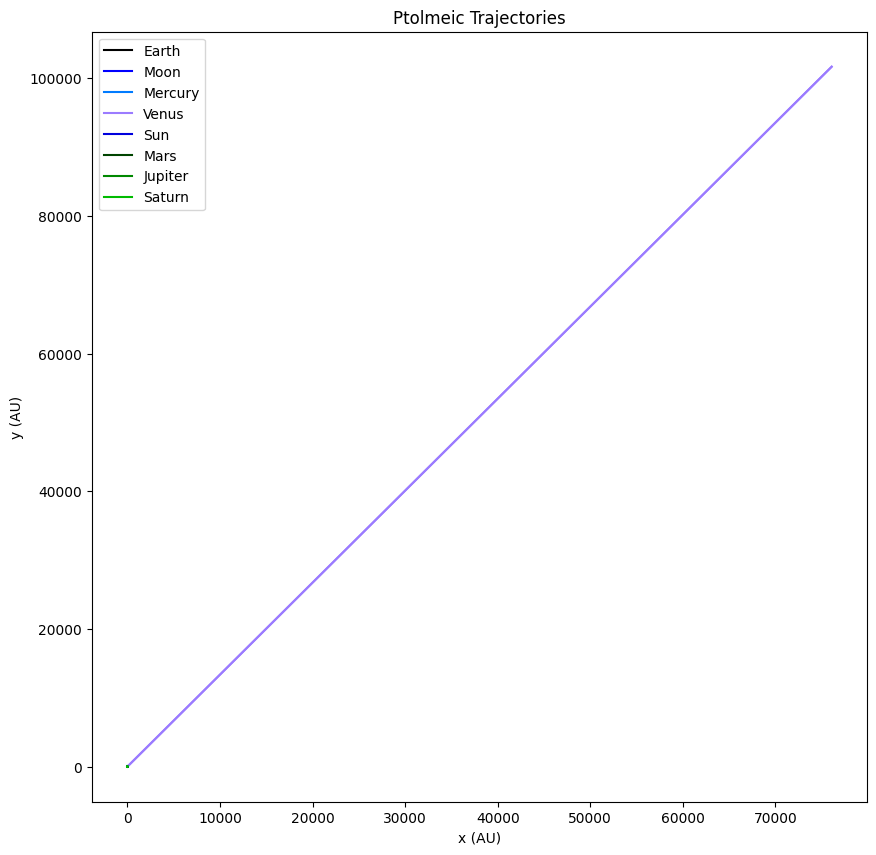

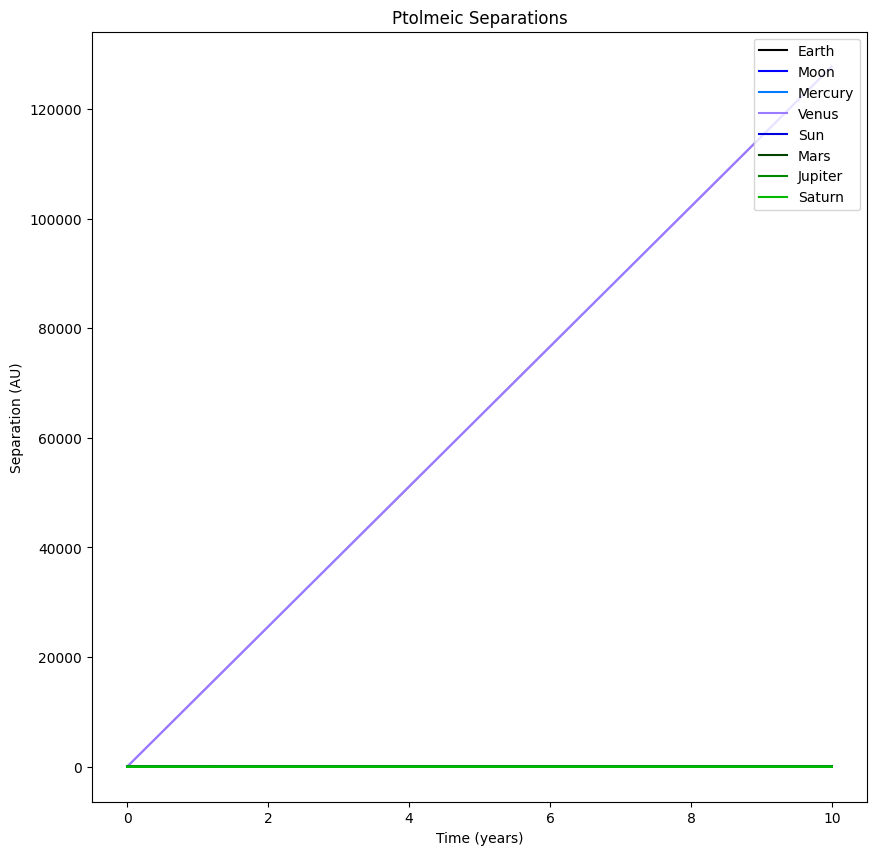

In [5]:
#Ptolmeic Model
#laptop C = 5.677867569029331e-05
#pc C = 7.17102e-5
ptol_objects = np.array(["Earth","Moon","Mercury","Venus","Sun","Mars","Jupiter","Saturn"]) 
ptol_init_pos={}
assign_pos(ptol_init_pos,positions,ptol_objects)
dt=0.00005
tmax= 10
c_ptol = 7.17102e-5
#calc_run_time(c_ptol,ptol_objects,tmax,dt)
#run_simulation("Ptolmeic",ptol_objects,ptol_init_pos,masses,initial_velocities,dt,tmax) 

dt = 0.0005
tmax = 10
calc_run_time(c_ptol,ptol_objects,tmax,dt)
run_simulation("Ptolmeic",ptol_objects,ptol_init_pos,masses,initial_velocities,dt,tmax) 


In [3]:
#Platonic geocentric model - Moon, Sun, Venus, Mercury, Mars, Jupiter, Saturn, various stars. 
plat_objects = np.array(["Earth","Moon","Sun","Venus","Mercury","Mars","Jupiter","Saturn"])
plat_init_pos={}
assign_pos(plat_init_pos,positions,plat_objects)
dt = 0.00005
tmax = 50
#pc C = 5.392354354262352e-05
#laptop C = 8.833909593522548e-05
c_plat = 5.392354354262352e-05
calc_run_time(c_plat,plat_objects,tmax,dt)
run_simulation("Platonic_1",plat_objects,plat_init_pos,masses,initial_velocities,dt,tmax)

dt = 0.0005
tmax = 500
calc_run_time(c_plat,plat_objects,tmax,dt)
run_simulation("Platonic_2",plat_objects,plat_init_pos,masses,initial_velocities,dt,tmax)


Expected runtime:  0  hours  57  minutes  31  seconds


KeyboardInterrupt: 

Expected runtime:  0  hours  8  minutes  41  seconds


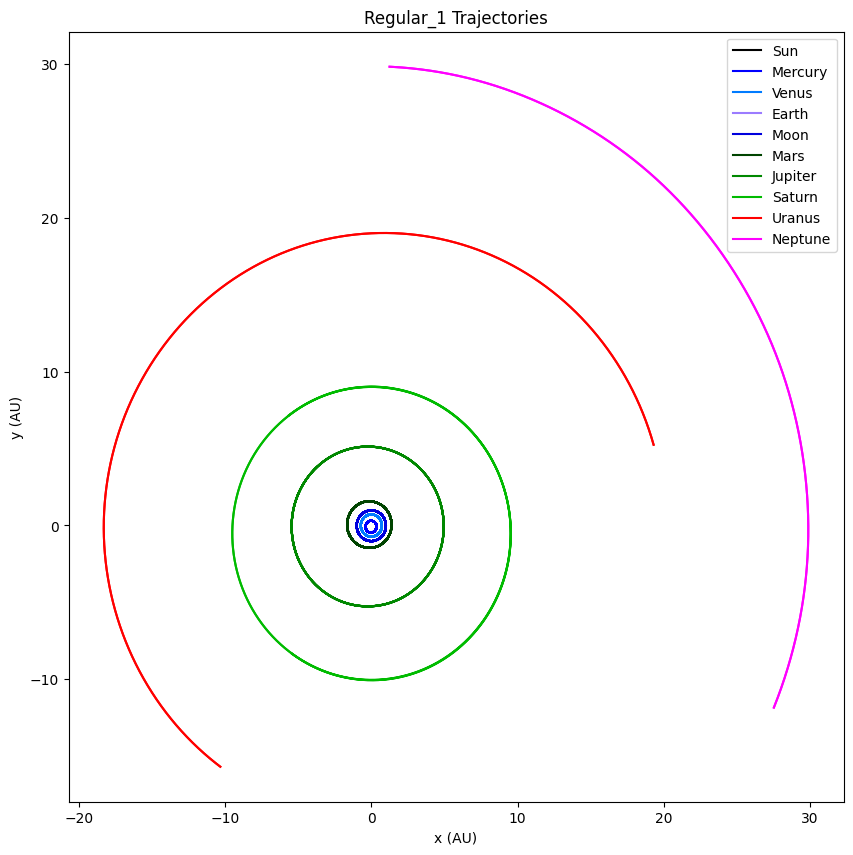

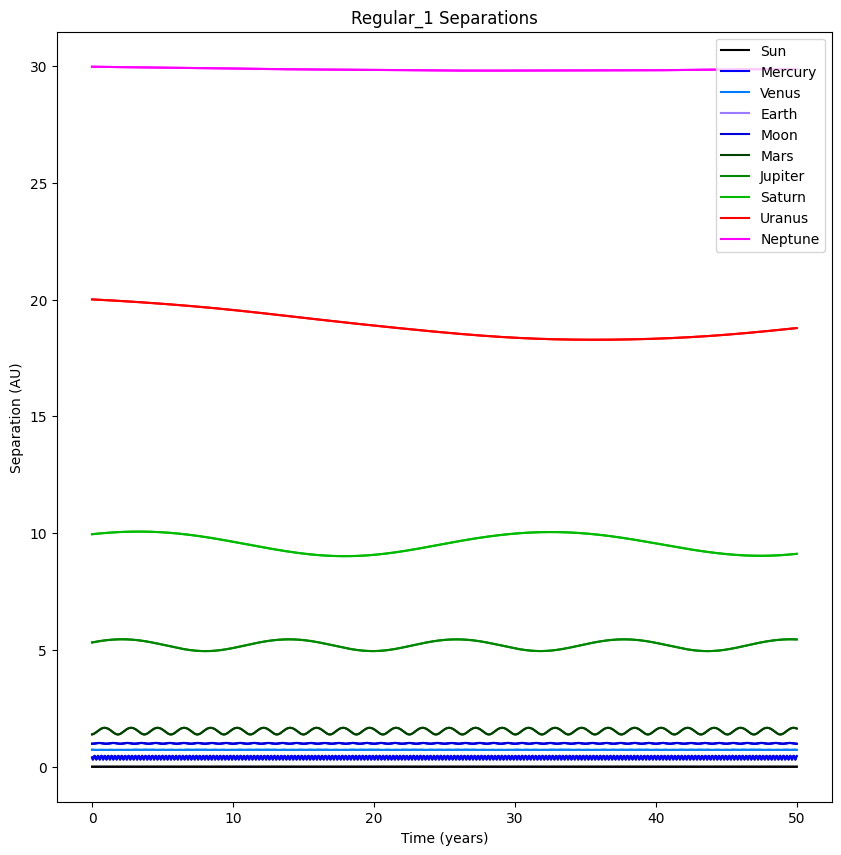

Expected runtime:  1  hours  26  minutes  50  seconds


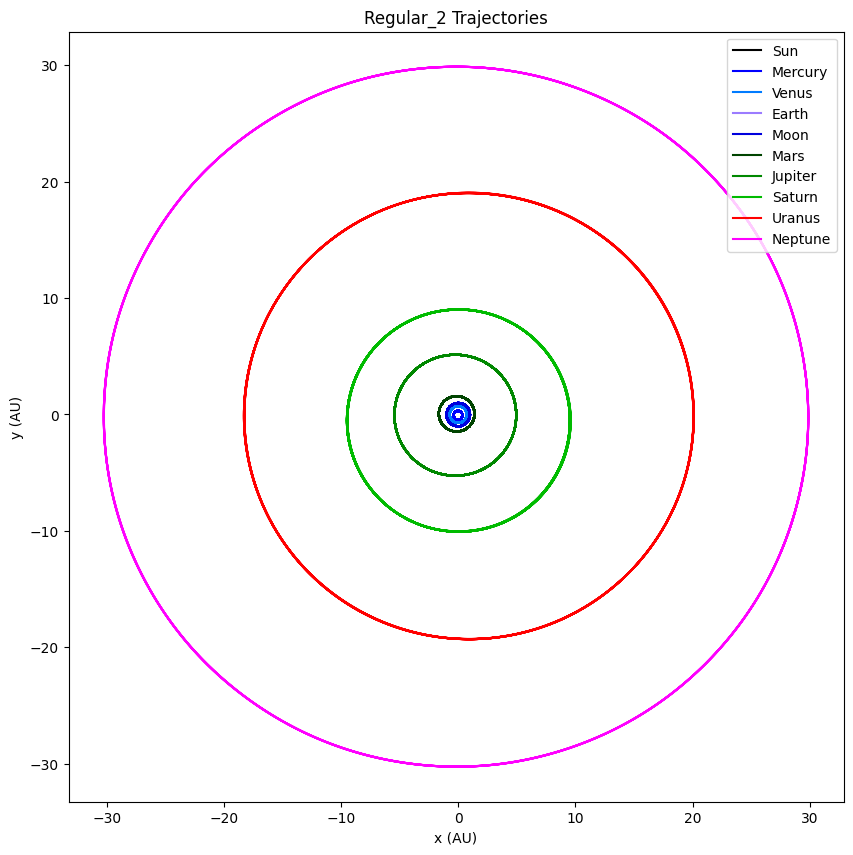

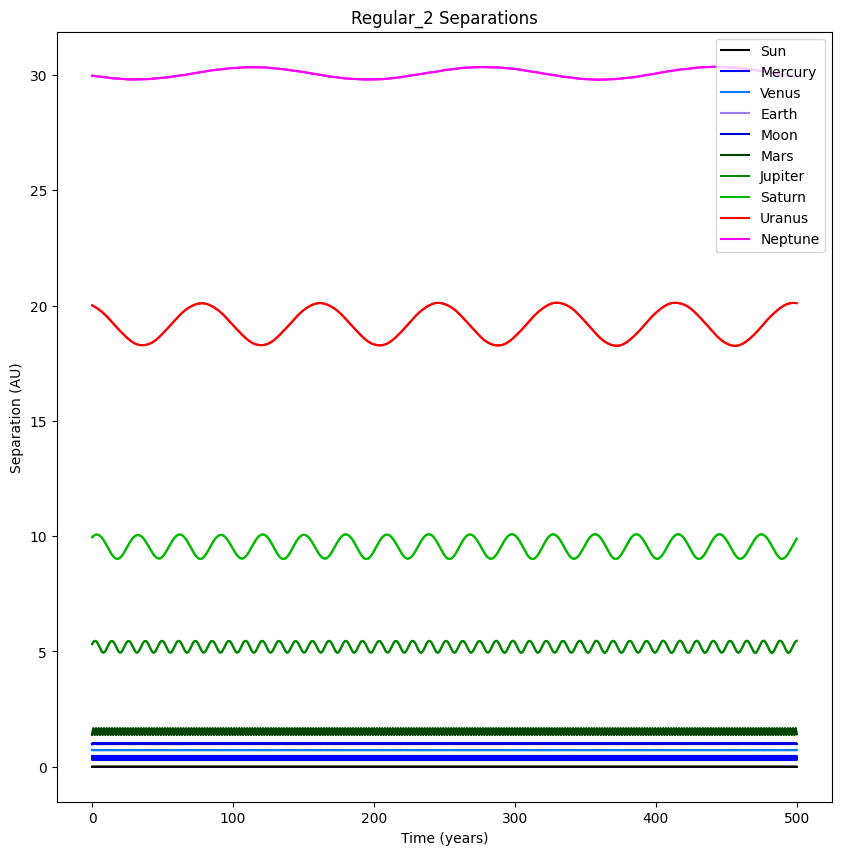

In [3]:
#Regular Model of the Universe
reg_objects = np.array(["Sun","Mercury","Venus","Earth","Moon","Mars","Jupiter","Saturn","Uranus","Neptune"])
reg_init_pos={}
assign_pos(reg_init_pos,positions,reg_objects)
dt=0.0005
tmax=50
#laptop c = 5.210237240791321e-05
#pc c = 8.130995392799378e-05
c_reg = 5.210237240791321e-05
calc_run_time(c_reg,reg_objects,tmax,dt)
run_simulation("Regular_1",reg_objects,reg_init_pos,masses,initial_velocities,dt,tmax) 

dt = 0.0005
tmax = 500
calc_run_time(c_reg,reg_objects,tmax,dt)
run_simulation("Regular_2",reg_objects,reg_init_pos,masses,initial_velocities,dt,tmax) 


Expected runtime:  0  hours  0  minutes  49  seconds


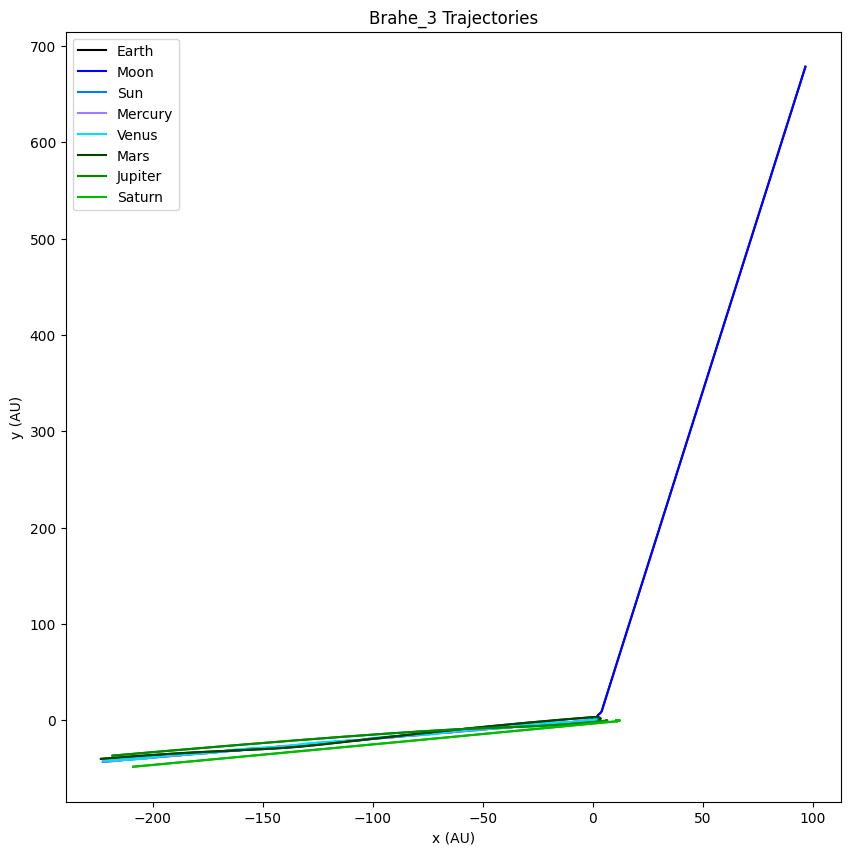

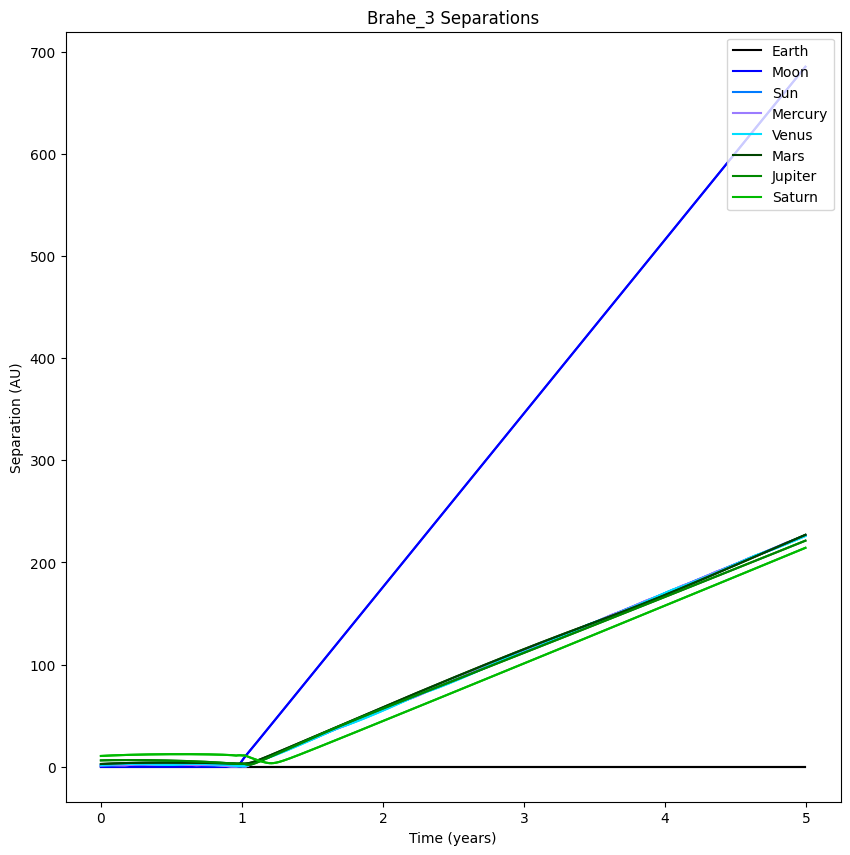

In [26]:
#Brahe Model - All the planets orbit the sun, and the moon and the sun orbit the earth, geocentric
br_objects = np.array(["Earth","Moon","Sun","Mercury","Venus","Mars","Jupiter","Saturn"])
br_init_pos = {}
br_init_pos["Earth"] = np.array([0,0,0])
br_init_pos["Moon"] = np.array([0.00257,0,0]) #Moon is about 0.00257 AU from the Earth 
br_init_pos["Sun"] = np.array([1,0,0]) #Sun is 1 AU from the Earth
#Position is calculated by the sun's distance from the earth + the planet's distance from the sun
br_init_pos["Mercury"] = np.array([1.4,0,0]) #Mercury is ~0.4 AU from the Sun
br_init_pos["Venus"] = np.array([1.7195,0,0]) #Venus is ~0.7195 AU from the Sun
br_init_pos["Mars"] = np.array([2.674,0,0]) #Mars is ~1.674 AU from the Sun
br_init_pos["Jupiter"] = np.array([6.2,0,0]) #Jupiter is ~5.2 AU from the Sun
br_init_pos["Saturn"] = np.array([10.53,0,0]) #Saturn is ~9.53 AU from the Sun

#Set initial velocity function using Kepler's Law
br_init_vel = {}
def br_set_init_vel(name): 
    r = br_init_pos[name][0]
    T = np.sqrt((4*np.pi**2*r**3)/(newtong))
    br_init_vel[name] = np.array([0,2*np.pi*r/T,0])

for i in range(1,len(br_objects)):
    br_set_init_vel(br_objects[i])

#Run Simulation
dt = 0.0005
tmax = 5
c_br = 7.751120440661907e-05
#laptop c=7.573167979717254e-05 or 6.86464449390769e-05
#pc c = 7.751120440661907e-05
calc_run_time(c_br, br_objects, tmax, dt)
run_simulation("Brahe_3",br_objects,br_init_pos,masses,initial_velocities,dt,tmax) 
